In [1]:
import pandas as pd
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',504)
pd.set_option('display.width',1000)

# Part A: Statistical analysis

## A1

What are popular trends on Twitter at the moment, either in the UK or worldwide?
Extract some insights from these trends such as: when it started in each place?
What devices are used to tweet? and what sources can you trust? Use plots, graphs
and maps to explain your insights.

### Imports

In [2]:
import time

import praw
import pandas as pd
import datetime as dt
from creds import bot_username, bot_pass, bot_ID, bot_token
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

from collections import Counter

import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
import pandas as pd

import numpy as np

import seaborn as sns
import pandas as pd

from matplotlib.dates import MonthLocator, DateFormatter


### API

#### Reddit API

In [3]:
def set_reddit_api():
    return praw.Reddit(
    client_id=bot_ID,
    client_secret=bot_token,
    password=bot_pass,
    user_agent=bot_ID,
    username=bot_username,
    )

#### Functions

In [4]:
def replace_chars(text):
    myDict = {  
                "\u2019"  : "'", 
                "\u200b" : "",
                "\u00a3" : "",
                "\u201d" : "",
                "\u201c" : "",
                "\u2018" : "",
                "\u2026" : "",
                "\n" : "",
                '''"''' : "'",
                "\\" : "'"
            }
    return "".join([myDict.get(c, c) for c in text])    

def dict_filter(original_dict):
    return_list = []
    for i in original_dict:
        temp_dict = {}
        temp_dict["coin_price"] = i["coin_price"]
        temp_dict["coin_reward"] = i["coin_reward"]
        temp_dict["description"] = i["description"]
        temp_dict["count"] = i["count"]
        temp_dict["name"] = i["name"]
        temp_dict["award_type"] = i["award_type"]
        return_list.append(temp_dict)
    return(return_list)
    
def get_reddit_data(filter_type = "new", subreddit_name = "ethereum"):
    reddit = set_reddit_api()
    li = []
    int_checker = lambda x: x if x != None else 0
    list_checker = lambda x: x if len(x) != 0 else []
    str_checker = lambda x: x if x != None else "u/[deleted]"
    submissions = None
    if filter_type == "new":
        submissions = reddit.subreddit(subreddit_name).new(limit=2000)
    elif filter_type == "top_all":
        submissions = reddit.subreddit(subreddit_name).top(time_filter="all", limit = 2000)
    
    for submission in submissions:
        temp_dict =  {
            #"all_awardings": dict_filter(list(list_checker(submission.all_awardings))),\
            "author": str(str_checker(submission.author)),\
            "author_is_blocked": bool(submission.author_is_blocked),\
            "awarders": list(list_checker(submission.awarders)),\
            "banned_at_utc": datetime.strptime(time.strftime('%d %b %Y %H:%M:%S', time.localtime(submission.banned_at_utc)), '%d %b %Y %H:%M:%S'),\
            "banned_by": str(str_checker(submission.banned_by)),\
            "can_gild": bool(submission.can_gild),\
            "category" : str(str_checker(submission.category)),\
            "created_utc": datetime.strptime(time.strftime('%d %b %Y %H:%M:%S', time.localtime(submission.created_utc)), '%d %b %Y %H:%M:%S'),\
            "downs": int(int_checker(submission.downs)),\
            "edited": bool(submission.edited),\
            "is_crosspostable": bool(submission.is_crosspostable),\
            "is_video": bool(submission.is_video),\
            "locked": bool(submission.locked),\
            "mod_note": str(str_checker(submission.mod_note)),\
            "mod_reason_by": str(str_checker(submission.mod_reason_by)),\
            "mod_reason_title": str(str_checker(submission.mod_reason_title)),\
            "mod_reports": str(str_checker(submission.mod_reports)),\
            "num_comments": int(int_checker(submission.num_comments)),\
            "num_crossposts": int(int_checker(submission.num_crossposts)),\
            "num_duplicates": int(int_checker(submission.num_duplicates)),\
            "num_reports": int(int_checker(submission.num_reports)),\
            "over_18": bool(submission.over_18),\
            "removal_reason": str(str_checker(submission.removal_reason)),\
            "removed_by": str(str_checker(submission.removed_by)),\
            "removed_by_category": str(str_checker(submission.removed_by_category)),\
            "score": int(int_checker(submission.score)),\
            "selftext": replace_chars(str(str_checker(submission.selftext))),\
            "spoiler": bool(submission.spoiler),\
            "title": replace_chars(str(str_checker(submission.title))),\
            "top_awarded_type" : str(str_checker(submission.top_awarded_type)),\
            "total_awards_received": int(int_checker(submission.total_awards_received)),\
            "ups": int(int_checker(submission.ups)),\
            "upvote_ratio": float(int_checker(submission.upvote_ratio)),\
            "url": str(str_checker(submission.url)),\
            "user_reports": list(list_checker(submission.user_reports)),
        }
        li.append(temp_dict)
    return li

def removeStopWords(txt):
    stop_words = set(stopwords.words("english"))
    filtered_sentence_selftext = []
    filtered_sentence_title = []
    
    for item in txt:
        selftext_list = item[0].split()
        selftext_title = item[1].split()
        for word in selftext_list:        
            if word not in stop_words:
                filtered_sentence_selftext.append(word)
        for word in selftext_title:        
            if word not in stop_words:
                filtered_sentence_title.append(word)
    
    return filtered_sentence_selftext, filtered_sentence_title

def get_top_mentioned_items(lst, le = 5):
    return Counter(lst).most_common()[0:le]

def save_data_locally(df,path):
    df.to_csv(path, index=False)
    
def generate_tree_map(data_frame, item_1, item_2, item_1_txt, item_2_txt, title):
    def format_label(item_1_val, item_2_val):
        return f"{item_1_txt}:\n{item_1_val}\n{item_2_txt}:\n{item_2_val}"

    squarify.plot(sizes=data_frame[item_1], 
                label=[format_label(item_1, item_2) for item_1, item_2 
                        in zip(data_frame[item_1], data_frame[item_2])],
                color=sns.color_palette("pastel", len(data_frame)))

    plt.title(title)
    plt.axis('off')
    plt.savefig(f"Graphs/{item_1}_treemap.png", dpi=300, bbox_inches='tight')
    #plt.clear()
    plt.close()
    
def generate_plot(data_frame, col_1, col_2, x_label, y_label, title):
    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
    # Create bars
    plt.bar(np.arange(len(data_frame[col_1])), data_frame[col_1],)

    # Create names on the x-axis
    plt.xticks(np.arange(len(data_frame[col_1])), data_frame[col_2])

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Show graphic
    #plt.show()
    plt.savefig(f"Graphs/{col_1}_plot.png", dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    #plt.clear()
    plt.close()
    
def generate_scatter_plot(data_frame, x_col, y_col, d_size, x_label, y_label, title):
    # use the scatterplot function to build the bubble map
    sns.scatterplot(data=data_frame, x=x_col, y=y_col, 
                    size=d_size, legend=False, sizes=(20, 2000), 
                    hue=d_size, 
                    palette = sns.color_palette("pastel", len(data_frame)))
    for i in range(len(data_frame)):
        plt.annotate(data_frame[d_size][i], (data_frame[x_col][i], data_frame[y_col][i]))
        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    # show the graph
    #plt.show()
    plt.savefig(f"Graphs/{x_col}_scatterplot.png", dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    #plt.clear()
    plt.close()
    
def count_author_upvotes(data_frame):
    # group by author and sum the upvotes
    author_upvotes = data_frame.groupby('author')['ups'].sum().reset_index()
    # count the number of occurrences of each author
    author_counts = data_frame['author'].value_counts().reset_index()
    author_counts.columns = ['author', 'number_of_occurrences']
    # merge the two dataframes on author
    result = pd.merge(author_upvotes, author_counts, on='author')
    return result.sort_values(by=['ups'], ascending=False)

def generate_scatter_plot_simple(data_frame,col_1, col_2, title):
    # create a scatter plot with 'ups' on the x-axis and 'number_of_occurrences' on the y-axis
    plt.scatter(data_frame[col_1], data_frame[col_2])

    # set the axis labels and title
    plt.xlabel(col_1)
    plt.ylabel(col_2)
    plt.title(title)

    # display the plot
    #plt.show()
    plt.savefig(f"Graphs/{col_1}_scatterplot_simple.png", dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    #plt.clear()
    plt.close()
    
def generate_double_histogram(data_frame, col_1, col_2, col_3, y_label_1, x_label, y_label_2, title):
    # Create a figure with two subplots
    # Create a figure with two subplots
    data = data_frame
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    fig.suptitle(title)
    
    # Plot the first bar chart for num_crossposts
    ax1.bar(range(len(data)), data[col_1])
    ax1.set_xticks(range(len(data)))
    ax1.set_xticklabels(data.index)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label_1)

    # Rotate the x-axis labels and add some spacing
    ax1.tick_params(axis='x', rotation=90, pad=10)

    # Plot the second bar chart for num_duplicates
    ax2.bar(range(len(data)), data[col_3])
    ax2.set_xticks(range(len(data)))
    ax2.set_xticklabels(data.index)
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label_2)

    # Rotate the x-axis labels and add some spacing
    ax2.tick_params(axis='x', rotation=90, pad=10)
    
    # Adjust the layout and display the chart
    fig.tight_layout()
    
    #plt.show()
    plt.savefig(f"Graphs/{col_1}_double_histogram.png", dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    #plt.clear()
    plt.close()
    
def generate_timeseries_plot(data_frame, col_1, x_label, y_label, title):
    # Convert the 'created_utc' column to datetime
    data_frame['created_utc'] = pd.to_datetime(data_frame['created_utc'])

    # Group the data by month and count the number of posts per month
    counts = data_frame.groupby(pd.Grouper(key=col_1, freq='M')).size()

    # Create a figure and axis
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)

    # Plot the data as a line chart
    ax.plot(counts.index, counts.values)

    # Set the x-axis ticks to show every 4 months
    ax.xaxis.set_major_locator(MonthLocator(interval=4))

    # Set the x-axis tick labels to display the month and year
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

    # Set the axis labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Set the title
    ax.set_title(title)

    # Show the plot
    #plt.show()
    plt.savefig(f"Graphs/{col_1}_timeseries.png", dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    #plt.clear()
    plt.close()

### Main

In [5]:
#l2 = get_reddit_data()

#top_eth = pd.DataFrame(get_reddit_data(filter_type="top_all", subreddit_name="ethereum"))
reddit_data_frame = pd.read_csv("Data/Reddit/merged_subredits.csv")
#new_eth = pd.DataFrame(get_reddit_data(filter_type="new", subreddit_name="ethereum"))


# Heatmap awards vs ups
generate_tree_map(reddit_data_frame[["total_awards_received","ups"]].head(10),
                  item_1 = "ups",
                  item_2 = "total_awards_received",
                  item_1_txt= "Upvotes",
                  item_2_txt= "Awards", 
                  title = "Upvotes and their rewards represented")

# Num of cross posts vs avards
generate_plot(reddit_data_frame[["num_crossposts","total_awards_received"]].head(10),
              col_1= "num_crossposts",
              col_2= "total_awards_received",
              x_label= "Total awards received",
              y_label= "Number of crossposts",
              title = "Number of rewards received per top posts associated with number of crossposts")

# Num of comments vs cross posts vs ups
generate_scatter_plot(reddit_data_frame[["num_crossposts","num_comments", "ups"]].head(10),
                      x_col="num_crossposts",
                      y_col="num_comments",
                      d_size="ups",
                      x_label = "Number of crossposts", 
                      y_label = "Number of comments",
                      title= "Number of comments linked to number of crossposts and number of upvotes")

# Author post number vs number of upvotes
#la3 = count_author_upvotes(top_eth).head(30)
generate_scatter_plot_simple(count_author_upvotes(reddit_data_frame).head(30), 
                             col_1="ups", 
                             col_2="number_of_occurrences", 
                             title="Correlation between Ups and Number of occurrences for Authors")

# Num of duplicates vs num of crossposts
lite_data = reddit_data_frame.sort_values(['num_crossposts', 'num_duplicates'], ascending=[False, False])
generate_double_histogram(lite_data.head(15), 
                          col_1="num_crossposts", 
                          col_2="Post", 
                          col_3="num_duplicates", 
                          y_label_1="Number of crossposts", 
                          x_label= "Posts", 
                          y_label_2= "Number of duplicates",
                          title="Posts crossposts compared to number of duplicates")

# Posts over time                          
generate_timeseries_plot(reddit_data_frame, 
                         col_1="created_utc", 
                         x_label = "Date", 
                         y_label = "Number of Posts", 
                         title = "Posts Over Time")


## A2

Use one of the graph datasets available in Stanford Large Network Dataset
Collection (https://snap.stanford.edu/data/) or any other publicly available graph
dataset (you can also create your own graph), apply the following:

• Find the most important nodes (individuals) in the network based on different centrality measures, </br>
• Visualise your graph using one of centrality measures of your choice, and </br>
• Apply a Community Detection Algorithm to the graph, visualise the communities and discuss your findings.

Use plots, graphs and maps to explain your insights.

### Imports

In [6]:
from creds import API_Key, urlBase
import json
import requests
from decimal import Decimal
from web3 import Web3
import pandas as pd
from pathlib import Path  
import os

### API

#### Etherscan API

In [7]:
def get_eth_block_number():
    return str(urlBase + 
               "?module=proxy" + 
               "&action=eth_blockNumber" + 
               f"&apikey={API_Key}")

def get_eth_block_by_number(block_number = "0xfe22dd"):
    return str(urlBase + 
    "?module=proxy" +
    "&action=eth_getBlockByNumber" +
    f"&tag={block_number}" +
    "&boolean=true" +
    f"&apikey={API_Key}")
    
def get_ether_last_price():
    return str(urlBase +
    "?module=stats" +
    "&action=ethprice" +
    f"&apikey={API_Key}")

#### Functions

In [8]:
def get_block():
    # Format a json
    format_as_json = json.dumps(requests.get(get_eth_block_number()).json())
    # Load data as a json
    load_as_json = json.loads(format_as_json)
    #print(load_as_json["result"])
    return load_as_json

def get_block_by_number(block_number = "0xfe2385"):
    format_as_json = json.dumps(requests.get(get_eth_block_by_number(block_number)).json())
    load_as_json = json.loads(format_as_json)
    return load_as_json

def get_eth_price():
    # Format a json
    format_as_json = json.dumps(requests.get(get_ether_last_price()).json())
    # Load data as a json
    load_as_json = json.loads(format_as_json)
    #print(load_as_json["result"])
    return load_as_json

def covert(amount, eth_price):
    amount = int(amount, 0)
    eth_amount = format(Web3.fromWei(amount, "ether"), '.18f')
    usd_amount = float(eth_amount) * eth_price
    return usd_amount

def transfer_data_from(block_number):
    df  = pd.DataFrame()
    eth_price = float(get_eth_price()["result"]["ethusd"])
    try:
        trx = get_block_by_number(block_number)["result"]["transactions"]
        for i in trx:
            temp_df = pd.DataFrame([[i["from"], 
                                     i["to"], 
                                     covert(i["value"], eth_price), 
                                     covert(i["gasPrice"], eth_price)]],
                                    columns=
                                    ["From", "To", "Value", "Gas_price"])
            df = pd.concat([df, temp_df])
        return df
    except:
        return df

def generate_data(block_number):
    print(f"Generating data for block: {block_number}")
    filepath = Path(f"Data/Crypto/MultiBlocks/{block_number}.csv")
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    data = transfer_data_from(block_number)
    data.to_csv(filepath)
    
def generate_blocks_in_range(block_range):
    for i in block_range:
        generate_data(i)

def generate_block_list(block_str = "0x1003e", start_block = 10, end_block = 91):
    block_range = []
    [block_range.append(f"{block_str}{i}") for i in range (start_block, end_block)]
    return block_range

def generate_data_frame():
    cols = ["Unnamed", "From", "To", "Value", "Gas_price"]
    block_df = pd.DataFrame(columns=cols)
    filenames= os.listdir("Data/Crypto/MultiBlocks")
    num_items = len(filenames)
    start = 0
    for filename in filenames: # loop through all the files and folders
        start += 1
        print(f"{start}/{num_items}")
        if filename.endswith('.csv'):
            block_df = block_df.append(pd.read_csv(f"Data/Crypto/MultiBlocks/{filename}"))

    block_df = block_df.reset_index()
    block_df = block_df.drop(['index', 'Unnamed', "Unnamed: 0"], axis=1)
    return block_df


### Main

In [9]:
#get_block()

#generate_data_frame()
big_df = generate_data_frame().rename(columns={"From": "Source", "To": "Target", "Value": "Weight"}).drop(columns=["Gas_price"])
big_df.insert(2, "Type", "directed")
big_df.to_csv("Data/Crypto/BigBlock/big_df.csv", index=False)

#list_of_blocks = generate_block_list(block_str = "0x10042", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x10043", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x10044", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x10045", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x10046", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x10047", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x10048", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x10049", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x1004a", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x1004b", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x1004c", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x1004d", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x1004e", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)
#list_of_blocks = generate_block_list(block_str = "0x1004f", start_block = 00, end_block = 99)
#generate_blocks_in_range(list_of_blocks)


1/1863
2/1863
3/1863
4/1863
5/1863
6/1863
7/1863
8/1863
9/1863
10/1863
11/1863
12/1863
13/1863
14/1863
15/1863
16/1863
17/1863
18/1863
19/1863
20/1863
21/1863
22/1863
23/1863
24/1863
25/1863
26/1863
27/1863
28/1863
29/1863
30/1863
31/1863
32/1863
33/1863
34/1863
35/1863
36/1863
37/1863
38/1863
39/1863
40/1863
41/1863
42/1863
43/1863
44/1863
45/1863
46/1863
47/1863
48/1863
49/1863
50/1863
51/1863
52/1863
53/1863
54/1863
55/1863
56/1863
57/1863
58/1863
59/1863
60/1863
61/1863
62/1863
63/1863
64/1863
65/1863
66/1863
67/1863
68/1863
69/1863
70/1863
71/1863
72/1863
73/1863
74/1863
75/1863
76/1863
77/1863
78/1863
79/1863
80/1863
81/1863
82/1863
83/1863
84/1863
85/1863
86/1863
87/1863
88/1863
89/1863
90/1863
91/1863
92/1863
93/1863
94/1863
95/1863
96/1863
97/1863
98/1863
99/1863
100/1863
101/1863
102/1863
103/1863
104/1863
105/1863
106/1863
107/1863
108/1863
109/1863
110/1863
111/1863
112/1863
113/1863
114/1863
115/1863
116/1863
117/1863
118/1863
119/1863
120/1863
121/1863
122/1863
123/1863
1

In [10]:
#b = get_block_by_number(block_number="0x1024f51")

In [11]:
#small_data = generate_data_frame().head(1000)

# Part B: Text mining

## B1

Choose an event/campaign that happened in the UK or worldwide recently (i.e.,
Brexit). Apply sentiment analysis to show users’ opinions about the topic on Twitter.
Represent your findings using statistical descriptive methods

### Imports

In [12]:
import praw
from creds import bot_username, bot_pass, bot_ID, bot_token
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datetime import datetime
import time
  # download the stopwords corpus

nltk.download('stopwords')
nltk.download('punkt')  # download the punkt tokenizer
nltk.download('averaged_perceptron_tagger')  # download the POS tagger
nltk.download('wordnet')  # download the WordNet lemmatizer and stemmer

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zanzver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zanzver/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zanzver/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/zanzver/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### API

#### Reddit API

In [13]:
def set_reddit_api():
    return praw.Reddit(
    client_id=bot_ID,
    client_secret=bot_token,
    password=bot_pass,
    user_agent=bot_ID,
    username=bot_username,
    )

#### Functions

In [14]:
def replace_chars(text):
    myDict = {  
                "\u2019"  : "'", 
                "\u200b" : "",
                "\u00a3" : "",
                "\u201d" : "",
                "\u201c" : "",
                "\u2018" : "",
                "\u2026" : "",
                "\n" : "",
                '''"''' : "'",
                "\\" : "'"
            }
    return "".join([myDict.get(c, c) for c in text])    

def dict_filter(original_dict):
    return_list = []
    for i in original_dict:
        temp_dict = {}
        temp_dict["coin_price"] = i["coin_price"]
        temp_dict["coin_reward"] = i["coin_reward"]
        temp_dict["description"] = i["description"]
        temp_dict["count"] = i["count"]
        temp_dict["name"] = i["name"]
        temp_dict["award_type"] = i["award_type"]
        return_list.append(temp_dict)
    return(return_list)
      
def get_reddit_data(filter_type = "new", subreddit_name = "ethereum"):
    reddit = set_reddit_api()
    li = []
    int_checker = lambda x: x if x != None else 0
    list_checker = lambda x: x if len(x) != 0 else []
    str_checker = lambda x: x if x != None else "u/[deleted]"
    submissions = None
    if filter_type == "new":
        submissions = reddit.subreddit(subreddit_name).new(limit=2000)
    elif filter_type == "top_all":
        submissions = reddit.subreddit(subreddit_name).top(time_filter="all", limit = 2000)
    
    for submission in submissions:
        temp_dict =  {
            #"all_awardings": dict_filter(list(list_checker(submission.all_awardings))),\
            "author": str(str_checker(submission.author)),\
            "author_is_blocked": bool(submission.author_is_blocked),\
            "awarders": list(list_checker(submission.awarders)),\
            "banned_at_utc": datetime.strptime(time.strftime('%d %b %Y %H:%M:%S', time.localtime(submission.banned_at_utc)), '%d %b %Y %H:%M:%S'),\
            "banned_by": str(str_checker(submission.banned_by)),\
            "can_gild": bool(submission.can_gild),\
            "category" : str(str_checker(submission.category)),\
            "created_utc": datetime.strptime(time.strftime('%d %b %Y %H:%M:%S', time.localtime(submission.created_utc)), '%d %b %Y %H:%M:%S'),\
            "downs": int(int_checker(submission.downs)),\
            "edited": bool(submission.edited),\
            "is_crosspostable": bool(submission.is_crosspostable),\
            "is_video": bool(submission.is_video),\
            "locked": bool(submission.locked),\
            "mod_note": str(str_checker(submission.mod_note)),\
            "mod_reason_by": str(str_checker(submission.mod_reason_by)),\
            "mod_reason_title": str(str_checker(submission.mod_reason_title)),\
            "mod_reports": str(str_checker(submission.mod_reports)),\
            "num_comments": int(int_checker(submission.num_comments)),\
            "num_crossposts": int(int_checker(submission.num_crossposts)),\
            "num_duplicates": int(int_checker(submission.num_duplicates)),\
            "num_reports": int(int_checker(submission.num_reports)),\
            "over_18": bool(submission.over_18),\
            "removal_reason": str(str_checker(submission.removal_reason)),\
            "removed_by": str(str_checker(submission.removed_by)),\
            "removed_by_category": str(str_checker(submission.removed_by_category)),\
            "score": int(int_checker(submission.score)),\
            "selftext": replace_chars(str(str_checker(submission.selftext))),\
            "spoiler": bool(submission.spoiler),\
            "title": replace_chars(str(str_checker(submission.title))),\
            "top_awarded_type" : str(str_checker(submission.top_awarded_type)),\
            "total_awards_received": int(int_checker(submission.total_awards_received)),\
            "ups": int(int_checker(submission.ups)),\
            "upvote_ratio": float(int_checker(submission.upvote_ratio)),\
            "url": str(str_checker(submission.url)),\
            "user_reports": list(list_checker(submission.user_reports)),
        }
        li.append(temp_dict)
    return li

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return ' '.join(filtered_tokens)

def stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    lemmatized_tokens = []
    for token, tag in tagged_tokens:
        # Convert the POS tag to the WordNet format
        wn_tag = get_wordnet_pos(tag)
        if wn_tag is None:
            # If the POS tag is not recognized, assume it's a noun
            wn_tag = wordnet.NOUN
        # Apply lemmatization to the token
        lemmatized_token = lemmatizer.lemmatize(token, wn_tag)
        lemmatized_tokens.append(lemmatized_token)
    return ' '.join(lemmatized_tokens)
    
def stem_and_lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    stem_lem_tokens = []
    for token, tag in tagged_tokens:
        # Convert the POS tag to the WordNet format
        wn_tag = get_wordnet_pos(tag)
        if wn_tag is None:
            # If the POS tag is not recognized, assume it's a noun
            wn_tag = wordnet.NOUN
        # Apply stemming and lemmatization to the token
        stem_lem_token = lemmatizer.lemmatize(stemmer.stem(token), wn_tag)
        stem_lem_tokens.append(stem_lem_token)
    return ' '.join(stem_lem_tokens)

# Define a helper function to convert POS tags to WordNet format
def get_wordnet_pos(tag):
    if tag[0] == 'N':
        return wordnet.NOUN
    elif tag[0] == 'V':
        return wordnet.VERB
    elif tag[0] == 'J':
        return wordnet.ADJ
    elif tag[0] == 'R':
        return wordnet.ADV
    else:
        return None
    
def create_freq_dist(series):
    # Tokenize the text in each row of the series
    tokens = series.apply(word_tokenize)

    # Flatten the list of tokens into a single list
    all_tokens = [token for row in tokens for token in row]

    # Create a frequency distribution of the tokens
    freq_dist = FreqDist(all_tokens)

    return freq_dist

def frequencyDistribution(txt, word_len = 0):
    frequency_dist = nltk.FreqDist(txt)
    sorted(frequency_dist, key=frequency_dist.__getitem__, reverse= True)
    return dict([k,v] for k, v in frequency_dist.items() if len(k) > word_len)

def create_word_cloud(data_frame):
    wordcloud = WordCloud().generate_from_frequencies(data_frame)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def replace_words(series, replace_dict):
    pattern = r'\b(' + '|'.join(replace_dict.keys()) + r')\b'
    return series.str.replace(pattern, lambda x: replace_dict[x.group()], regex=True)
   
def run_all(data_frame):
    # Words to lowercase
    df_lower_title = data_frame.str.lower()

    # Remove stop words
    df_lower_title_no_stopwords = df_lower_title.apply(remove_stopwords)

    # Apply regex
    pattern = r'[^a-zA-Z0-9\s]'
    df_lower_title_no_stopwords = df_lower_title_no_stopwords.str.replace(pattern, '').str.replace("'s", '')
    
    # Replace characters
    replace_dict = {
        "btc": "bitcoin", "eth": "ethereum", "u": "you", "s":"", "m": "am"
    }

    df_lower_title_no_stopwords = replace_words(df_lower_title_no_stopwords, replace_dict)
    
    # Apply steaming
    df_lower_title_no_stopwords_steamed = df_lower_title_no_stopwords.apply(stem_text)

    # Apply lemmatization
    df_lower_title_no_stopwords_lamma = df_lower_title_no_stopwords.apply(lemmatize_text)

    # Apply steam and lemmatization
    df_lower_title_no_stopwords_steamd_lemma = df_lower_title_no_stopwords.apply(stem_and_lemmatize_text)

    # Create frequency distribution
    df_lower_title_no_stopwords_steamd_lemma_frequency_dist = create_freq_dist(df_lower_title_no_stopwords_steamd_lemma)
    # for item in df_lower_title_no_stopwords_steamd_lemma_frequency_dist.most_common():
    #     print(item)
    
    # Word cloud
    create_word_cloud(df_lower_title_no_stopwords_steamd_lemma_frequency_dist)
    
def create_big_dataframe(custom_filter_type="top_all",type="top"):
    top_ethereum = pd.DataFrame(get_reddit_data(filter_type=custom_filter_type, subreddit_name="ethereum"))
    top_bitcoin = pd.DataFrame(get_reddit_data(filter_type=custom_filter_type, subreddit_name="Bitcoin"))
    top_cryptocurrency = pd.DataFrame(get_reddit_data(filter_type=custom_filter_type, subreddit_name="CryptoCurrency"))
    if((len(top_ethereum) + len(top_bitcoin) + len(top_cryptocurrency)) == len(result)):
        print("Same lenght")
        frames = [top_ethereum, top_bitcoin, top_cryptocurrency]
        result = pd.concat(frames)
        result.to_csv(f"Data/Reddit/{type}_merged_subredits.csv", index=False)
    else:
        print("Error")

### Main

#### Use downloaded data

<ipython-input-14-3643d768d629>:177: FutureWarning: The default value of regex will change from True to False in a future version.
  df_lower_title_no_stopwords = df_lower_title_no_stopwords.str.replace(pattern, '').str.replace("'s", '')


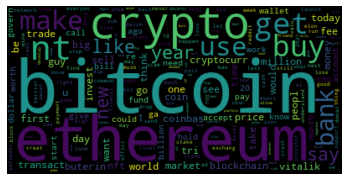

In [15]:
# calculate polarity on ML/deep learning
result = pd.read_csv("Data/Reddit/merged_subredits.csv")
run_all(data_frame=result["title"])

<ipython-input-14-3643d768d629>:177: FutureWarning: The default value of regex will change from True to False in a future version.
  df_lower_title_no_stopwords = df_lower_title_no_stopwords.str.replace(pattern, '').str.replace("'s", '')


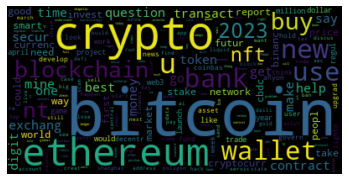

In [16]:
new_result = pd.read_csv("Data/Reddit/new_merged_subredits.csv")
run_all(data_frame=new_result["title"])

#### Use Reddit API

In [17]:
#read_subreddit = pd.DataFrame(get_reddit_data(filter_type="top_all", subreddit_name="ethereum"))
#run_all(data_frame=read_subreddit["title"])

In [18]:
#read_subreddit = pd.DataFrame(get_reddit_data(filter_type="top_all", subreddit_name="ethereum"))
#run_all(data_frame=read_subreddit["title"])

In [19]:
#read_subreddit = pd.DataFrame(get_reddit_data(filter_type="new", subreddit_name="ethereum"))
#run_all(data_frame=read_subreddit["title"])

In [20]:
#read_subreddit = pd.DataFrame(get_reddit_data(filter_type="top_all", subreddit_name="Bitcoin"))
#run_all(data_frame=read_subreddit["title"])

In [21]:
#read_subreddit = pd.DataFrame(get_reddit_data(filter_type="new", subreddit_name="Bitcoin"))
#run_all(data_frame=read_subreddit["title"])

In [22]:
#read_subreddit = pd.DataFrame(get_reddit_data(filter_type="top_all", subreddit_name="CryptoCurrency"))
#run_all(data_frame=read_subreddit["title"])

In [23]:
#read_subreddit = pd.DataFrame(get_reddit_data(filter_type="new", subreddit_name="CryptoCurrency"))
#run_all(data_frame=read_subreddit["title"])

#### Create local data

In [24]:
#create_big_dataframe(custom_filter_type="top_all",type="top")

In [25]:
#create_big_dataframe(custom_filter_type="new",type="new")

## B2

Access News APIs for articles related to the chosen event/campaign (Minimum of 5 articles)

• Perform all required cleaning and pre-processing on the articles. </br>
• Perform basic descriptive analysis of the collected articles (time distribution, word counts. etc).</br>
• Use topic modelling techniques to discover key topics. Display your findings using proper graphs, such as word cloud.</br>
• Provide a summary on one of the news articles. Comment on the summarisation quality

### Import

In [26]:

from creds import news_api_key
from dateutil import parser
#from textblob import TextBlob

from datetime import datetime
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer

import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

from wordcloud import WordCloud

import matplotlib.pyplot as plt

import pandas as pd 
from gensim.summarization import summarize # gensim must be 3.8

import requests

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zanzver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zanzver/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Functions

In [27]:
def get_news(api_key, search_items):
    # specify the endpoint and parameters for the API request
    url = 'https://newsapi.org/v2/everything'
    params = {
        'apiKey': api_key,
        'q': search_items,
        'sortBy': 'publishedAt',
        'language': 'en'
    }
    
    # send the API request and get the response
    response = requests.get(url, params=params)
    data = response.json()
    
    # extract the title and news source for each article
    articles = []
    for article in data['articles']:
        print(article)
        title = article['title'].encode('utf-8').decode('ascii', 'ignore')
        source = article['source']['name'].encode('utf-8').decode('ascii', 'ignore')
        description = article['description'].encode('utf-8').decode('ascii', 'ignore').replace('\n', '') if article['description'] else ""
        url = article['url']
        publishedAt = int(datetime.fromisoformat(article['publishedAt'][:-1]).timestamp())
        content = article['content'].encode('utf-8').decode('ascii', 'ignore') if article['content'] else ""
        articles.append({'title': title, 'source': source, 'description': description, 'url': url, 'publishedAt': publishedAt, 'content': content})
    
    df = pd.DataFrame(articles)
    return df

def remove_stopwords(df):
    stop_words = set(stopwords.words('english'))

    df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
    df['description'] = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
    df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

    return df

def apply_regex(data_frame):
    # define a regular expression pattern to match only alphanumeric characters
    pattern = r'[^a-zA-Z0-9 ]'

    # apply the regular expression to the title, description, and content columns of the DataFrame
    data_frame['title'] = data_frame['title'].apply(lambda x: re.sub(pattern, '', x))
    data_frame['description'] = data_frame['description'].apply(lambda x: re.sub(pattern, '', x))
    data_frame['content'] = data_frame['content'].apply(lambda x: re.sub(pattern, '', x))
    return data_frame

def apply_stemming(df):
    stemmer = PorterStemmer()

    df['title'] = df['title'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
    df['description'] = df['description'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
    df['content'] = df['content'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

    return df

def apply_lemmatization(df):
    lemmatizer = WordNetLemmatizer()

    df['title'] = df['title'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))
    df['description'] = df['description'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))
    df['content'] = df['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

    return df

def apply_stemming_and_lemmatization(df):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    df['title'] = df['title'].apply(lambda x: ' '.join([lemmatizer.lemmatize(stemmer.stem(word)) for word in word_tokenize(x)]))
    df['description'] = df['description'].apply(lambda x: ' '.join([lemmatizer.lemmatize(stemmer.stem(word)) for word in word_tokenize(x)]))
    df['content'] = df['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(stemmer.stem(word)) for word in word_tokenize(x)]))

    return df

def discover_topics(df, num_topics=5, num_words=10):
    data = df[['title', 'description', 'content']].values.tolist()
    data = [' '.join(simple_preprocess(str(d))) for d in data]
    tokens = [d.split() for d in data]

    dictionary = Dictionary(tokens)
    corpus = [dictionary.doc2bow(doc) for doc in tokens]

    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)

    topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)

    topics_df = pd.DataFrame(columns=['topic_words'])

    for topic in topics:
        topic_id = topic[0]
        topic_words = [word[0] for word in topic[1]]
        topic_words = ', '.join(topic_words)
        topics_df = topics_df.append({'topic_words': topic_words}, ignore_index=True)

    return topics_df

def generate_wordclouds(df):
    for col in ['title', 'description', 'content']:
        data = df[col].values.tolist()
        data = ' '.join([' '.join(str(d).split()) for d in data])
        wordcloud = WordCloud(width=800, height=500, background_color='white', max_words=100, contour_width=3, contour_color='steelblue')
        wordcloud.generate(data)
        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(col.capitalize() + ' Word Cloud')
        plt.show()
        
def plot_source_pie(df, n=5):
    source_counts = df['source'].value_counts().head(n)
    plt.pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%')
    plt.title(f"Top {n} Sources")
    plt.axis('equal')
    plt.show()

def plot_publication_dates(df):
    dates = pd.to_datetime(df['publishedAt'], unit='s')
    dates_counts = dates.value_counts().sort_index()
    dates_counts.plot()
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.title('Publication Dates')
    plt.show()
    
def plot_word_count(data_frame):
    # Concatenate the 'title', 'description', and 'content' columns into a single Series
    text_all = pd.concat([data_frame['title'], data_frame['description'], data_frame['content']]).astype(str).str.lower().str.cat(sep=' ')

    # Count the frequency of each word in the text
    word_counts_all = Counter(text_all.split())

    # Get the top 10 most common words
    top_words_all = word_counts_all.most_common(10)

    # Loop over each column and create a chart
    for col in ['title', 'description', 'content', 'all']:
        if col == 'all':
            text = text_all
            word_counts = word_counts_all
        else:
            text = data_frame[col].astype(str).str.lower().str.cat(sep=' ')
            word_counts = Counter(text.split())

        # Get the top 10 most common words for this column
        top_words = word_counts.most_common(10)

        # Print the word count for this column
        word_count = len(text.split())
        print(f"Number of words in {col}: {word_count}")

        # Create a pie chart of the top 10 most common words
        plt.pie([count for _, count in top_words], labels=[word for word, _ in top_words])
        plt.title(f'Top 10 words in {col}')
        plt.show()
        
def summarize_description(df):
    # Check if the DataFrame has a 'description' column
    if 'description' not in df.columns:
        raise ValueError("DataFrame doesn't have a 'description' column.")

    # Iterate over each row in the DataFrame and summarize the text in the 'description' column
    summaries = []
    for index, row in df.iterrows():
        description = row['description']
        if len(description.split('.')) == 1:
            # If the text contains only one sentence, return it as the summary
            summaries.append(description)
        else:
            # Otherwise, summarize the text using gensim's summarize function
            try:
                summary = summarize(description, word_count=30)
                summaries.append(summary)
            except ValueError:
                # If the input has no valid sentences, return the original text
                summaries.append(description)

    # Create a new DataFrame with the summarized text
    summary_df = pd.DataFrame({'summary': summaries})

    return summary_df

### Main

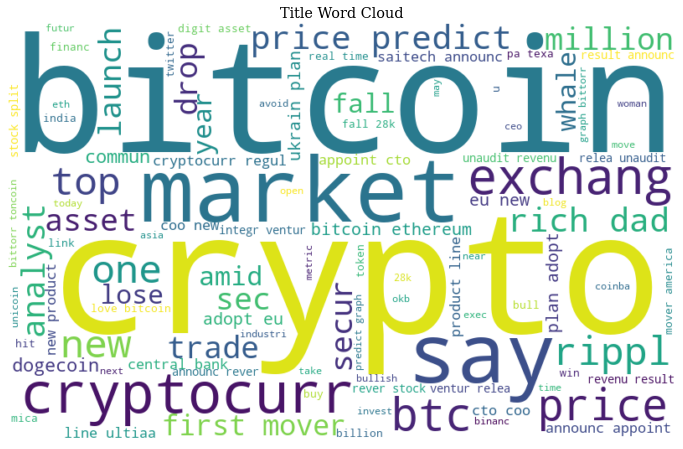

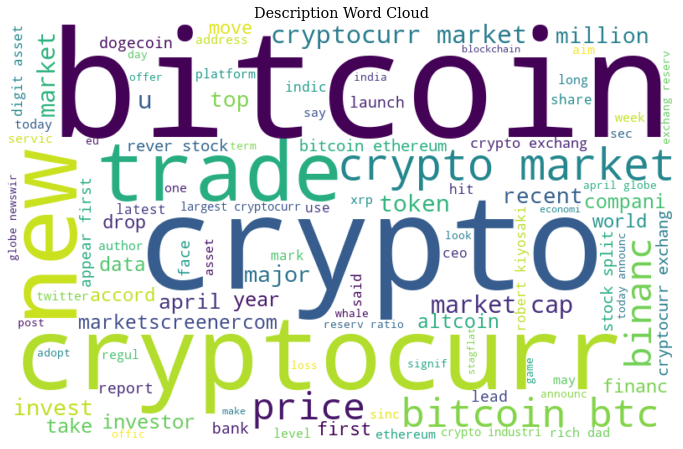

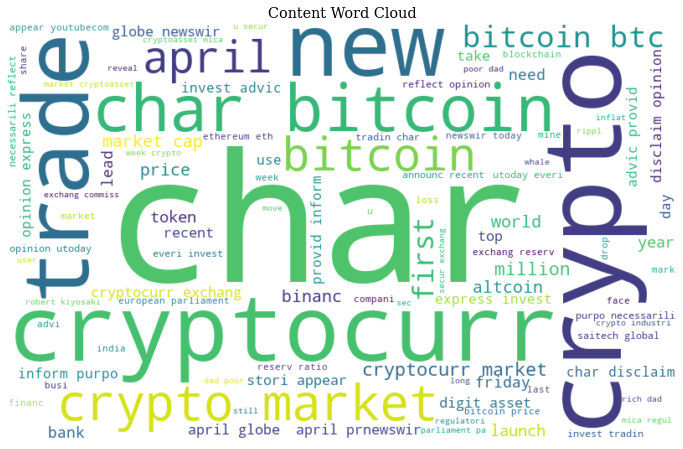

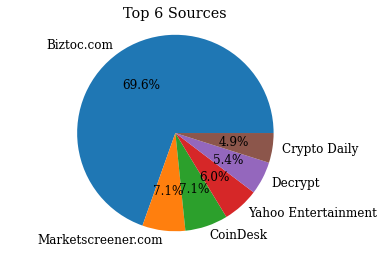

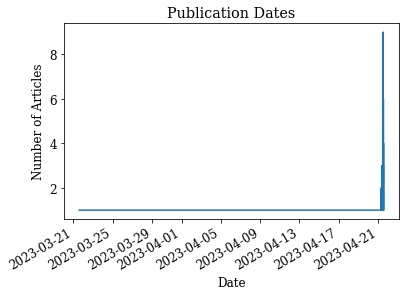

Number of words in title: 2645


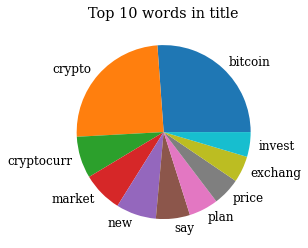

Number of words in description: 6647


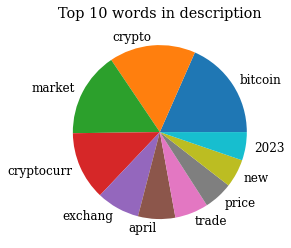

Number of words in content: 6700


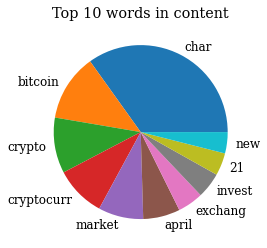

Number of words in all: 15992


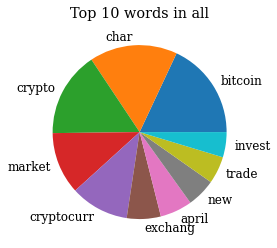

In [28]:
#news = get_news(news_api_key,"bitcoin")
news_bitcoin = pd.read_csv("Data/News/bitcoin.csv", index_col=0)
news_etherium = pd.read_csv("Data/News/etherium.csv", index_col=0)
news_crypto = pd.read_csv("Data/News/crypto.csv", index_col=0)
news_cryptocurrency = pd.read_csv("Data/News/cryptocurrency.csv", index_col=0)

frames = [news_bitcoin, news_etherium, news_crypto, news_cryptocurrency]
news_all = pd.concat(frames)

# Apply regex
news_all = apply_regex(news_all)

news_stopwords = remove_stopwords(news_all)

apply_stemming(news_stopwords)[["title","description","content"]]
apply_lemmatization(news_stopwords)[["title","description","content"]]
news_stem_lemma = apply_stemming_and_lemmatization(news_stopwords)[["title","description","content"]]
#news_stopwords[["title","description","content"]]
topics = discover_topics(news_stopwords, num_topics=6, num_words=10)
topics
generate_wordclouds(news_stopwords)


plot_source_pie(news_all, n=6)
plot_publication_dates(news_all)
plot_word_count(news_stem_lemma)

#summarize_description(news_stem_lemma)

# Tests

In [29]:
#list_of_blocks = generate_block_list()

In [30]:
#big_df = generate_data_frame().rename(columns={"From": "Source", "To": "Target", "Value": "Weight"}).drop(columns=["Gas_price"])
#big_df.insert(2, "Type", "directed")
#big_df.to_csv("Data/mrg6.csv", index=False)

In [31]:
#a = generate_block_list(start_block=1, end_block=3)

In [32]:
#generate_blocks_in_range(a)

In [33]:
#generate_blocks_in_range(list_of_blocks)

In [34]:
#import sys
#imported_modules = list(sys.modules.keys())
#for module in imported_modules:
#    del module
#print(imported_modules)

In [35]:
#import sys
#imported_modules = list(sys.modules.keys())